In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time
import tensorflow as tf
from tensorflow import keras

from keras import Input, layers
from keras.preprocessing import image
from keras.layers import Reshape
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model

from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import load_model

## model for feature extract

In [3]:
model_incv3 = keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    pooling='avg',
    classifier_activation="softmax",
)

model_rnv2 = keras.applications.ResNet50V2(
    include_top=True,
    weights="imagenet",
    pooling='avg',
    classifier_activation="softmax",
)

In [4]:
model_incv3_v1 = Model(model_incv3.input, model_incv3.layers[-2].output)
model_rnv2_v1 = Model(model_rnv2.input, model_rnv2.layers[-2].output)

In [5]:
caption_model_v1 = load_model('incv3_lstm_model.h5')
caption_model_v2 = load_model('incv3_resnetv2_lstm_model.h5')

In [6]:
max_length = 38
vocab = open('vocab.txt', 'r').read().strip().split('\n')

ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [7]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def preprocess2(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.resnet_v2.preprocess_input(x)
    return x

In [8]:
def encode(image_byme):
    image = preprocess(image_byme) 
    fea_vec = model_incv3_v1.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

def encode2(image):
    image = preprocess2(image) 
    fea_vec = model_rnv2_v1.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [9]:
def greedySearch_v1(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        #print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_length)
        sequence = np.array(sequence)
        yhat = model.predict([photo,sequence], verbose=0) #here we must pass the encoded image otw error show failed to find data adapter
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


def greedySearch_v2(photo1, photo2, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        #print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo1, photo2, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [10]:
def beam_search_predictions_v1(image, model, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image, par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption


def beam_search_predictions_v2(image1, image2, model, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image1, image2, par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [16]:
image_name = os.listdir(r"../testingImage/")
image_path = '../testingImage/'

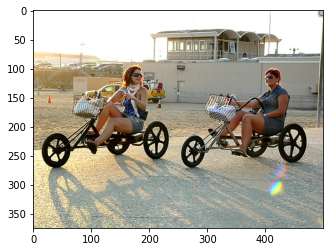

Prediction from model_v1 ::
Greedy Search:======> a child is riding a bike in a parking lot
Beam Search(K=10):==> a boy in a red shirt is riding a go cart down a paved road

Prediction from model_v2 ::
Greedy Search:======> a dog covering his fingers on her nose
Beam Search(K=10):==> a closeup of a finger showing his neck


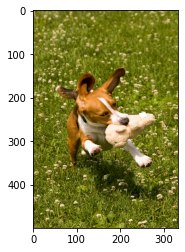

Prediction from model_v1 ::
Greedy Search:======> a beagle is running through a field
Beam Search(K=10):==> a brown and white dog plays with a toy

Prediction from model_v2 ::
Greedy Search:======> a finger sticking his nose on his nose
Beam Search(K=10):==> someone licks his nose at the nose of his nose


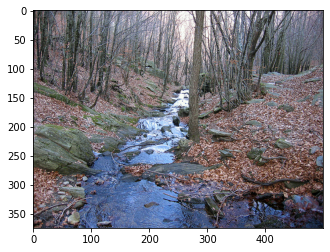

Prediction from model_v1 ::
Greedy Search:======> a man in a red jacket is climbing a fallen tree
Beam Search(K=10):==> a large group of people are walking through a river

Prediction from model_v2 ::
Greedy Search:======> a dog covering his mouth and is licking his nose
Beam Search(K=10):==> a closeup of a dog licking his nose


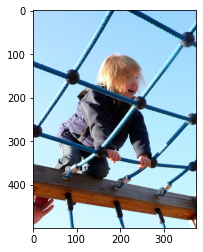

Prediction from model_v1 ::
Greedy Search:======> a young boy is jumping off a wooden slide
Beam Search(K=10):==> a group of children play on a park bench

Prediction from model_v2 ::
Greedy Search:======> a dog covering his face has his fingers on her nose
Beam Search(K=10):==> a closeup of a finger showing his nose


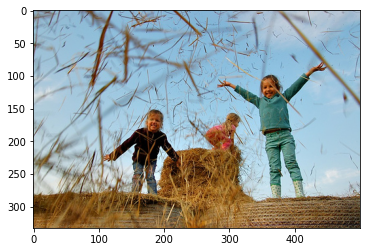

Prediction from model_v1 ::
Greedy Search:======> a small child in a pink shirt is walking through a field of tall grass
Beam Search(K=10):==> a girl in a pink shirt is walking through the grass

Prediction from model_v2 ::
Greedy Search:======> the dog covering his fingers on nose
Beam Search(K=10):==> someone licks his nose on the nose


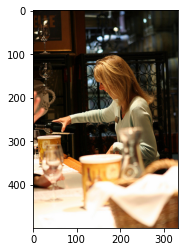

Prediction from model_v1 ::
Greedy Search:======> a man with a beard and a cast smile at the camera
Beam Search(K=10):==> a man and a woman posing for the camera

Prediction from model_v2 ::
Greedy Search:======> a closeup of a dog licking his nose
Beam Search(K=10):==> a closeup of a dog licking his nose


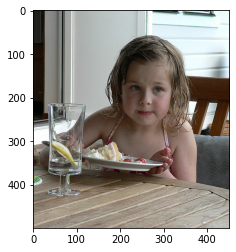

Prediction from model_v1 ::
Greedy Search:======> a young boy is licking a blue and yellow tube
Beam Search(K=10):==> there is a white and brown dog drinking from a mug cone

Prediction from model_v2 ::
Greedy Search:======> the nose has his fingers on her nose
Beam Search(K=10):==> the nose has his fingers on his nose


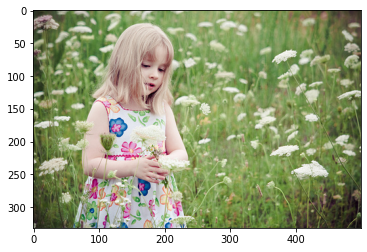

Prediction from model_v1 ::
Greedy Search:======> a little girl in a pink jumper is walking on a path
Beam Search(K=10):==> a little girl in a striped dress is running through a grassy area

Prediction from model_v2 ::
Greedy Search:======> a dog licking his nose
Beam Search(K=10):==> a closeup of a finger showing his nose


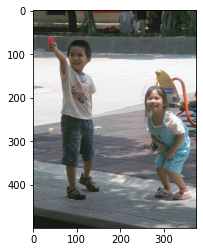

Prediction from model_v1 ::
Greedy Search:======> a boy in a red shirt is walking along a path
Beam Search(K=10):==> a group of children play in the water at the beach

Prediction from model_v2 ::
Greedy Search:======> a dog licking his nose
Beam Search(K=10):==> the dog eating his fingers on his nose


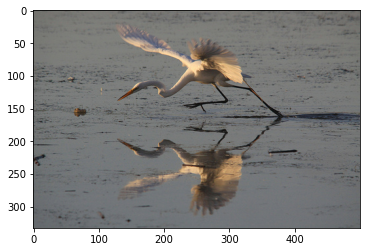

Prediction from model_v1 ::
Greedy Search:======> a white crane with a black and black bird is flying over water
Beam Search(K=10):==> the white dog is running through the water

Prediction from model_v2 ::
Greedy Search:======> a closeup of a dog licking her nose
Beam Search(K=10):==> a closeup of a dog licking her nose


In [17]:
for oneimg in image_name:
    full_img_path = image_path+str(oneimg)
    
    encoded_img1 = encode( full_img_path )
    encoded_img1 = encoded_img1.reshape(1,2048)
    encoded_img2 = encode2( full_img_path )
    encoded_img2 = encoded_img2.reshape(1,2048)
    
    x = plt.imread(full_img_path)
    plt.imshow(x)
    plt.show()
    print("Prediction from model_v1 ::")
    print("Greedy Search:======>",greedySearch_v1(encoded_img1,caption_model_v1))
    print("Beam Search(K=10):==>",beam_search_predictions_v1(encoded_img1,caption_model_v1, beam_index = 10))
    
    print("\nPrediction from model_v2 ::")
    print("Greedy Search:======>",greedySearch_v2(encoded_img1, encoded_img2, caption_model_v2))
    print("Beam Search(K=10):==>",beam_search_predictions_v2(encoded_img1, encoded_img2, caption_model_v2, beam_index = 10))